# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = '/input'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Extracting mnist: 100%|██████████| 60.0K/60.0K [00:11<00:00, 5.30KFile/s] 


Extracting celeba...


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

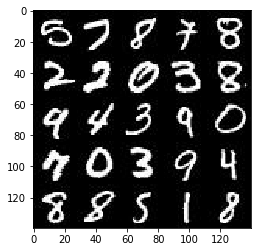

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

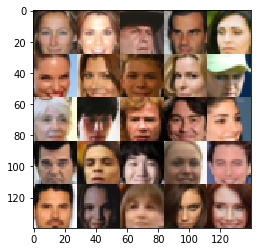

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_real = tf.placeholder(tf.float32, shape=[None, image_width, image_height, image_channels], name='input_real') 
    input_z = tf.placeholder(tf.float32, shape=[None, z_dim], name='input_z')
    learning_rate = tf.placeholder(tf.float32, shape=None, name='learning_rate')
    return input_real, input_z, learning_rate



"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    alpha=0.2
    x = images
    with tf.variable_scope('discriminator', reuse=reuse):
        x1 = tf.layers.conv2d(x, 64, 5, strides=2, padding="same")
        bn1 = tf.layers.batch_normalization(x1, training=True)
        relu1 = tf.maximum(alpha * bn1, bn1)
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding="same")
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding="same")
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        
        flat = tf.reshape(relu3, (-1, 4 * 4 * 256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)

    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha=0.2
    reuse = not is_train
    with tf.variable_scope('generator', reuse=reuse):
        x1 = tf.layers.dense(z, 4 * 4 * 512)     
        x1 = tf.reshape(x1, (-1, 4, 4, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=1, padding="same")
        x2 = tf.layers.batch_normalization(x2,training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding="same")
        x3 = tf.layers.batch_normalization(x3,training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=2, padding="same")
        out = tf.tanh(logits)
    return out

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    d_model_real, d_logits_real = discriminator(input_real, reuse=False)
    fake = generator(input_z, out_channel_dim, is_train=True)
    d_logits_fake = discriminator(fake, reuse=True)
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real,labels=tf.ones_like(d_logits_real) * (0.9)))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,labels=tf.zeros_like(d_logits_fake)))
    d_loss = d_loss_real + d_loss_fake
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_logits_fake)))
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    all_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    g_update_ops = [var for var in all_update_ops if var.name.startswith('generator')]
    d_update_ops = [var for var in all_update_ops if var.name.startswith('discriminator')]
    
    with tf.control_dependencies(d_update_ops):
        d_train_opt = tf.train.AdamOptimizer(learning_rate,beta1=beta1).minimize(d_loss, var_list=d_vars)
    with tf.control_dependencies(g_update_ops):
        g_train_opt = tf.train.AdamOptimizer(learning_rate,beta1=beta1).minimize(g_loss, var_list=g_vars)
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    inputs_real, inputs_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(inputs_real, inputs_z, data_shape[-1])
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    step = 0 
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                step += 1
                batch_images *= 2
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                #print('batch_z shape=',batch_z.shape)
                # Run optimizers
                _ = sess.run(d_train_opt, feed_dict={inputs_real: batch_images, inputs_z: batch_z, lr:learning_rate})
                _ = sess.run(g_train_opt, feed_dict={inputs_z: batch_z, lr:learning_rate})
                
                if step % 100 == 0:
                    train_loss_d = d_loss.eval({inputs_z:batch_z, inputs_real: batch_images})
                    train_loss_g = g_loss.eval({inputs_z:batch_z})
                    print("Epoch {}/{} Step {}...".format(epoch_i+1, epoch_count, step),
                      "Discriminator Loss: {:.4f}...".format(train_loss_d),
                      "Generator Loss: {:.4f}".format(train_loss_g))    

                if step % 200 == 0:
                    show_generator_output(sess, 25, inputs_z, data_shape[3], data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/10 Step 100... Discriminator Loss: 1.2081... Generator Loss: 1.3460
Epoch 1/10 Step 200... Discriminator Loss: 1.1805... Generator Loss: 1.0290


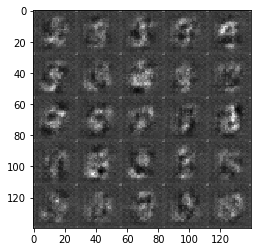

Epoch 1/10 Step 300... Discriminator Loss: 1.3500... Generator Loss: 0.4858
Epoch 1/10 Step 400... Discriminator Loss: 1.0967... Generator Loss: 0.7441


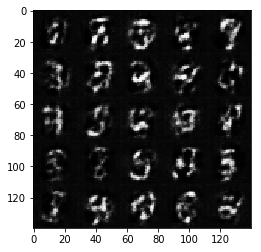

Epoch 1/10 Step 500... Discriminator Loss: 1.1290... Generator Loss: 0.6785
Epoch 1/10 Step 600... Discriminator Loss: 1.3110... Generator Loss: 1.1425


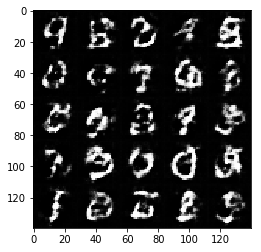

Epoch 1/10 Step 700... Discriminator Loss: 1.1678... Generator Loss: 0.6432
Epoch 1/10 Step 800... Discriminator Loss: 1.1521... Generator Loss: 0.7883


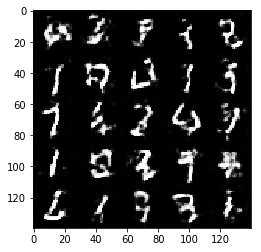

Epoch 1/10 Step 900... Discriminator Loss: 1.4626... Generator Loss: 0.4147
Epoch 2/10 Step 1000... Discriminator Loss: 1.2927... Generator Loss: 1.0636


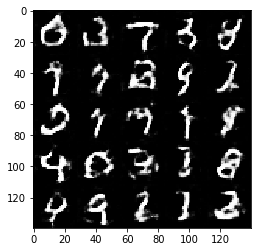

Epoch 2/10 Step 1100... Discriminator Loss: 1.4098... Generator Loss: 0.4361
Epoch 2/10 Step 1200... Discriminator Loss: 1.4671... Generator Loss: 0.4150


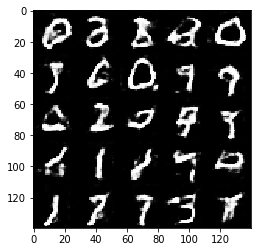

Epoch 2/10 Step 1300... Discriminator Loss: 1.5276... Generator Loss: 0.3887
Epoch 2/10 Step 1400... Discriminator Loss: 1.3051... Generator Loss: 0.5026


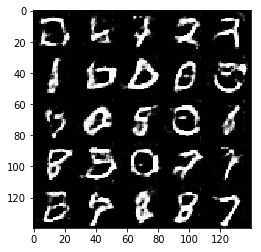

Epoch 2/10 Step 1500... Discriminator Loss: 1.2988... Generator Loss: 1.1336
Epoch 2/10 Step 1600... Discriminator Loss: 1.2410... Generator Loss: 0.7966


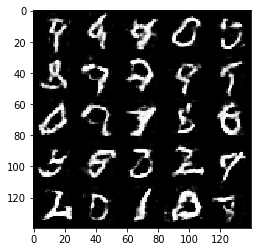

Epoch 2/10 Step 1700... Discriminator Loss: 1.1725... Generator Loss: 0.6271
Epoch 2/10 Step 1800... Discriminator Loss: 1.0961... Generator Loss: 0.7787


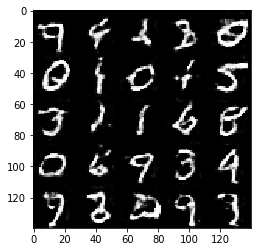

Epoch 3/10 Step 1900... Discriminator Loss: 1.2016... Generator Loss: 1.2016
Epoch 3/10 Step 2000... Discriminator Loss: 1.1497... Generator Loss: 0.6671


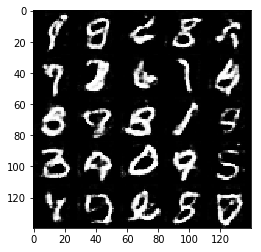

Epoch 3/10 Step 2100... Discriminator Loss: 1.1161... Generator Loss: 0.7018
Epoch 3/10 Step 2200... Discriminator Loss: 1.1800... Generator Loss: 1.4004


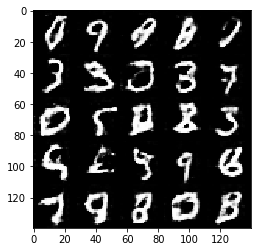

Epoch 3/10 Step 2300... Discriminator Loss: 0.9522... Generator Loss: 1.2531
Epoch 3/10 Step 2400... Discriminator Loss: 0.9568... Generator Loss: 1.0527


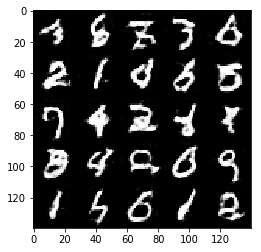

Epoch 3/10 Step 2500... Discriminator Loss: 1.6930... Generator Loss: 0.3526
Epoch 3/10 Step 2600... Discriminator Loss: 1.2292... Generator Loss: 1.2717


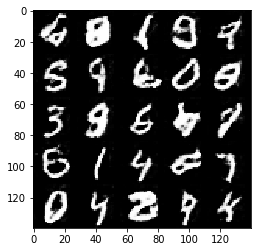

Epoch 3/10 Step 2700... Discriminator Loss: 2.0299... Generator Loss: 0.2927
Epoch 3/10 Step 2800... Discriminator Loss: 1.0036... Generator Loss: 1.0434


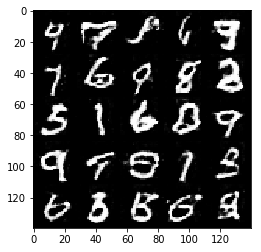

Epoch 4/10 Step 2900... Discriminator Loss: 1.1071... Generator Loss: 0.6962
Epoch 4/10 Step 3000... Discriminator Loss: 0.9343... Generator Loss: 1.0036


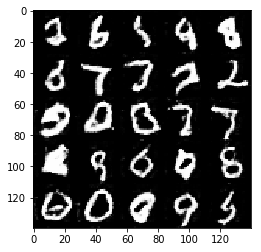

Epoch 4/10 Step 3100... Discriminator Loss: 1.4666... Generator Loss: 0.4439
Epoch 4/10 Step 3200... Discriminator Loss: 0.9468... Generator Loss: 1.0126


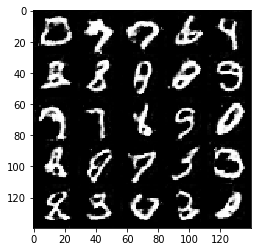

Epoch 4/10 Step 3300... Discriminator Loss: 0.9165... Generator Loss: 1.0521
Epoch 4/10 Step 3400... Discriminator Loss: 1.0102... Generator Loss: 0.8430


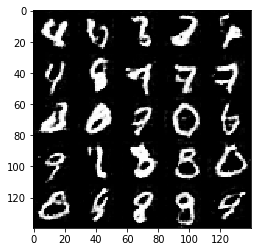

Epoch 4/10 Step 3500... Discriminator Loss: 0.9474... Generator Loss: 0.9797
Epoch 4/10 Step 3600... Discriminator Loss: 1.0327... Generator Loss: 0.7988


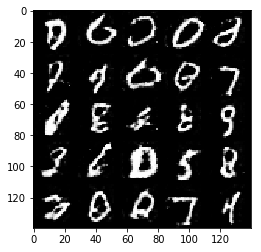

Epoch 4/10 Step 3700... Discriminator Loss: 2.0810... Generator Loss: 0.2829
Epoch 5/10 Step 3800... Discriminator Loss: 1.0289... Generator Loss: 0.8191


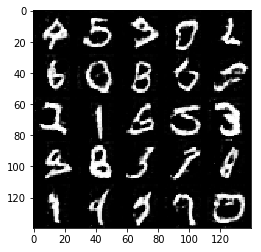

Epoch 5/10 Step 3900... Discriminator Loss: 1.0279... Generator Loss: 1.3765
Epoch 5/10 Step 4000... Discriminator Loss: 0.9018... Generator Loss: 1.2091


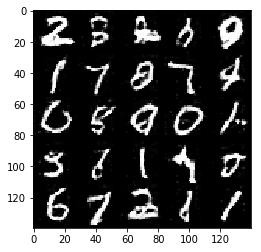

Epoch 5/10 Step 4100... Discriminator Loss: 0.9251... Generator Loss: 1.1714
Epoch 5/10 Step 4200... Discriminator Loss: 1.0526... Generator Loss: 0.7617


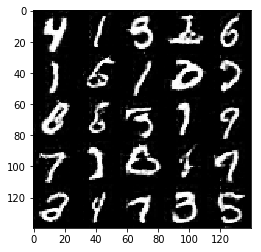

Epoch 5/10 Step 4300... Discriminator Loss: 1.1384... Generator Loss: 0.6694
Epoch 5/10 Step 4400... Discriminator Loss: 1.0671... Generator Loss: 0.7910


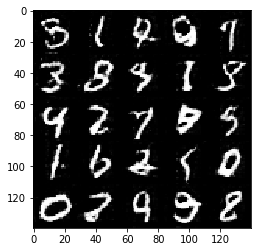

Epoch 5/10 Step 4500... Discriminator Loss: 1.3081... Generator Loss: 0.5558
Epoch 5/10 Step 4600... Discriminator Loss: 1.1542... Generator Loss: 0.6625


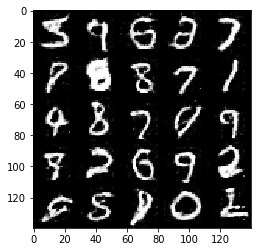

Epoch 6/10 Step 4700... Discriminator Loss: 0.8744... Generator Loss: 1.2796
Epoch 6/10 Step 4800... Discriminator Loss: 1.0519... Generator Loss: 1.2609


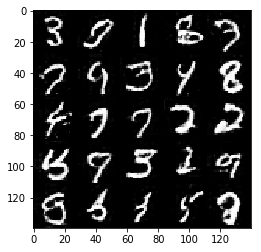

Epoch 6/10 Step 4900... Discriminator Loss: 0.9296... Generator Loss: 0.9967
Epoch 6/10 Step 5000... Discriminator Loss: 1.0220... Generator Loss: 0.8506


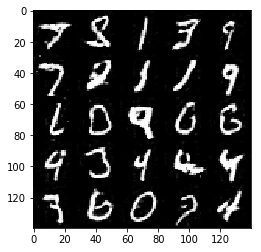

Epoch 6/10 Step 5100... Discriminator Loss: 0.9834... Generator Loss: 0.9035
Epoch 6/10 Step 5200... Discriminator Loss: 0.9002... Generator Loss: 1.2157


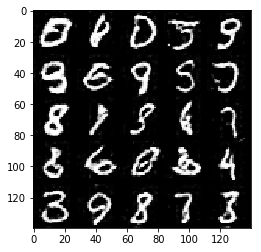

Epoch 6/10 Step 5300... Discriminator Loss: 0.8586... Generator Loss: 1.2117
Epoch 6/10 Step 5400... Discriminator Loss: 0.9763... Generator Loss: 0.9407


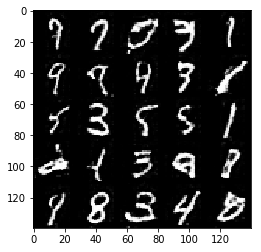

Epoch 6/10 Step 5500... Discriminator Loss: 0.9370... Generator Loss: 1.1868
Epoch 6/10 Step 5600... Discriminator Loss: 1.2528... Generator Loss: 0.5854


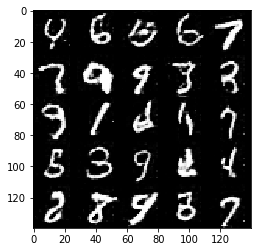

Epoch 7/10 Step 5700... Discriminator Loss: 1.0569... Generator Loss: 0.8221
Epoch 7/10 Step 5800... Discriminator Loss: 0.9332... Generator Loss: 1.3633


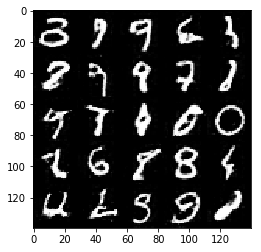

Epoch 7/10 Step 5900... Discriminator Loss: 0.9005... Generator Loss: 1.0914
Epoch 7/10 Step 6000... Discriminator Loss: 1.3284... Generator Loss: 0.5356


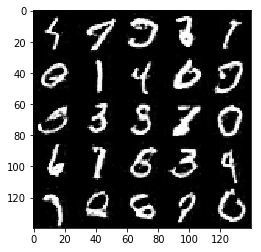

Epoch 7/10 Step 6100... Discriminator Loss: 1.0771... Generator Loss: 0.7392
Epoch 7/10 Step 6200... Discriminator Loss: 0.9291... Generator Loss: 1.0673


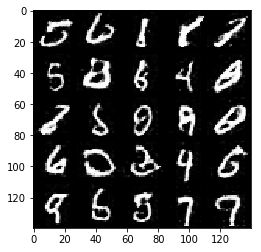

Epoch 7/10 Step 6300... Discriminator Loss: 1.8814... Generator Loss: 0.3466
Epoch 7/10 Step 6400... Discriminator Loss: 1.8681... Generator Loss: 0.3210


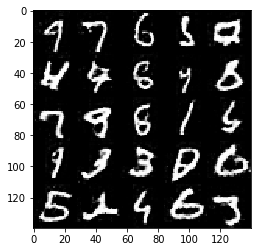

Epoch 7/10 Step 6500... Discriminator Loss: 1.0112... Generator Loss: 1.3491
Epoch 8/10 Step 6600... Discriminator Loss: 0.9687... Generator Loss: 0.9505


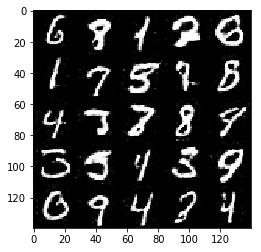

Epoch 8/10 Step 6700... Discriminator Loss: 1.1540... Generator Loss: 0.6540
Epoch 8/10 Step 6800... Discriminator Loss: 1.3083... Generator Loss: 0.5235


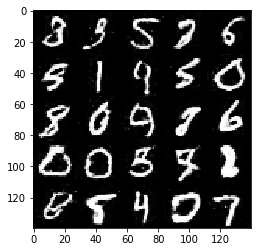

Epoch 8/10 Step 6900... Discriminator Loss: 0.9606... Generator Loss: 1.1030
Epoch 8/10 Step 7000... Discriminator Loss: 0.8581... Generator Loss: 1.1867


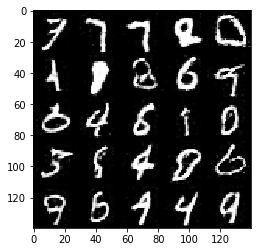

Epoch 8/10 Step 7100... Discriminator Loss: 0.8108... Generator Loss: 1.4015
Epoch 8/10 Step 7200... Discriminator Loss: 0.9578... Generator Loss: 0.9928


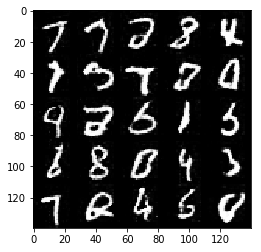

Epoch 8/10 Step 7300... Discriminator Loss: 0.9919... Generator Loss: 0.8944
Epoch 8/10 Step 7400... Discriminator Loss: 0.9721... Generator Loss: 0.9047


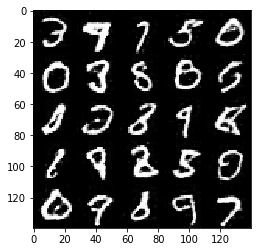

Epoch 9/10 Step 7500... Discriminator Loss: 1.1537... Generator Loss: 0.6628
Epoch 9/10 Step 7600... Discriminator Loss: 0.9416... Generator Loss: 0.9979


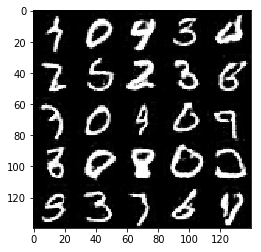

Epoch 9/10 Step 7700... Discriminator Loss: 0.8952... Generator Loss: 1.1046
Epoch 9/10 Step 7800... Discriminator Loss: 1.1987... Generator Loss: 0.6904


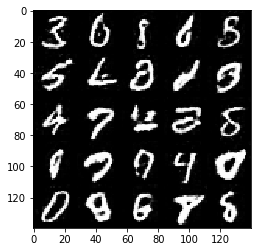

Epoch 9/10 Step 7900... Discriminator Loss: 0.8463... Generator Loss: 1.2610
Epoch 9/10 Step 8000... Discriminator Loss: 1.2481... Generator Loss: 0.6140


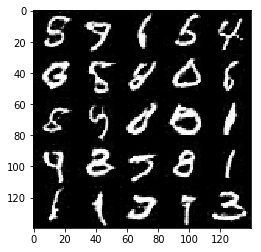

Epoch 9/10 Step 8100... Discriminator Loss: 0.9754... Generator Loss: 0.8739
Epoch 9/10 Step 8200... Discriminator Loss: 0.8228... Generator Loss: 1.2809


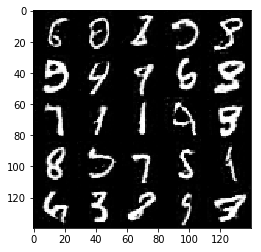

Epoch 9/10 Step 8300... Discriminator Loss: 1.0061... Generator Loss: 1.3690
Epoch 9/10 Step 8400... Discriminator Loss: 1.1136... Generator Loss: 0.7196


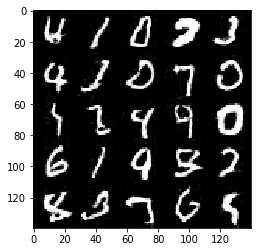

Epoch 10/10 Step 8500... Discriminator Loss: 1.0408... Generator Loss: 0.8992
Epoch 10/10 Step 8600... Discriminator Loss: 0.7502... Generator Loss: 1.7393


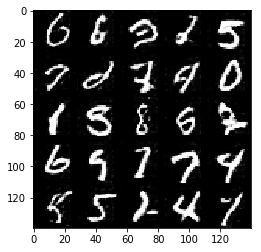

Epoch 10/10 Step 8700... Discriminator Loss: 1.0761... Generator Loss: 0.7866
Epoch 10/10 Step 8800... Discriminator Loss: 0.9164... Generator Loss: 1.0683


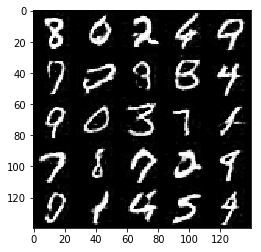

Epoch 10/10 Step 8900... Discriminator Loss: 1.3260... Generator Loss: 0.5837
Epoch 10/10 Step 9000... Discriminator Loss: 1.3439... Generator Loss: 0.5646


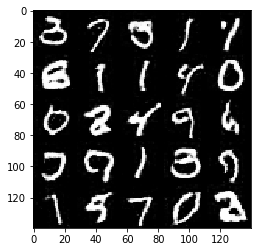

Epoch 10/10 Step 9100... Discriminator Loss: 0.8697... Generator Loss: 1.1303
Epoch 10/10 Step 9200... Discriminator Loss: 0.8800... Generator Loss: 1.2138


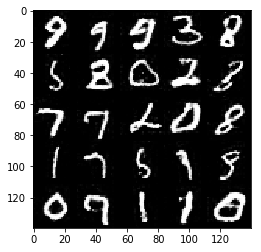

Epoch 10/10 Step 9300... Discriminator Loss: 0.9732... Generator Loss: 0.9177


In [12]:
batch_size = 64
z_dim = 100
learning_rate = 0.0001
beta1 = 0.2


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 10

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/7 Step 100... Discriminator Loss: 1.2458... Generator Loss: 0.7508
Epoch 1/7 Step 200... Discriminator Loss: 1.3337... Generator Loss: 1.0322


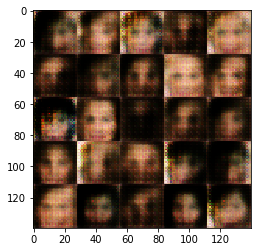

Epoch 1/7 Step 300... Discriminator Loss: 1.4631... Generator Loss: 0.4591
Epoch 1/7 Step 400... Discriminator Loss: 1.5425... Generator Loss: 0.5440


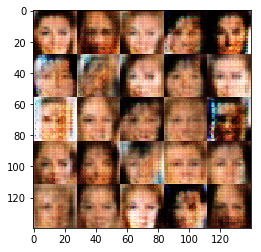

Epoch 1/7 Step 500... Discriminator Loss: 1.5170... Generator Loss: 0.4467
Epoch 1/7 Step 600... Discriminator Loss: 1.5576... Generator Loss: 1.0948


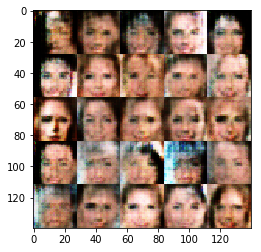

Epoch 1/7 Step 700... Discriminator Loss: 1.2884... Generator Loss: 0.6332
Epoch 1/7 Step 800... Discriminator Loss: 1.3805... Generator Loss: 0.5914


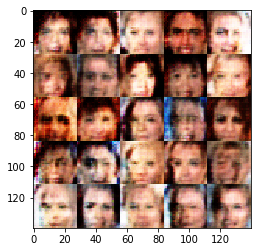

Epoch 1/7 Step 900... Discriminator Loss: 1.5112... Generator Loss: 0.7813
Epoch 1/7 Step 1000... Discriminator Loss: 1.5695... Generator Loss: 0.6550


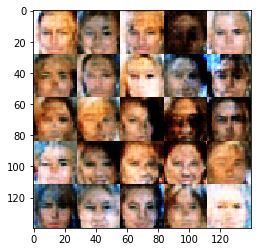

Epoch 1/7 Step 1100... Discriminator Loss: 1.3716... Generator Loss: 0.6505
Epoch 1/7 Step 1200... Discriminator Loss: 1.3585... Generator Loss: 1.1456


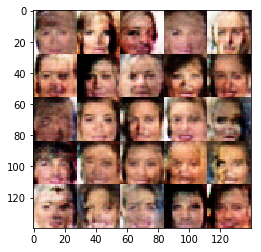

Epoch 1/7 Step 1300... Discriminator Loss: 1.2764... Generator Loss: 0.6592
Epoch 1/7 Step 1400... Discriminator Loss: 1.3261... Generator Loss: 0.6115


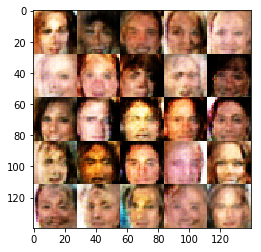

Epoch 1/7 Step 1500... Discriminator Loss: 1.2999... Generator Loss: 0.8114
Epoch 2/7 Step 1600... Discriminator Loss: 1.3717... Generator Loss: 0.5995


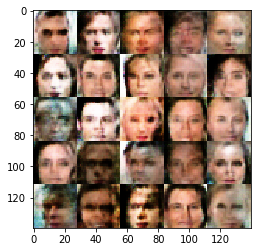

Epoch 2/7 Step 1700... Discriminator Loss: 1.4400... Generator Loss: 0.6557
Epoch 2/7 Step 1800... Discriminator Loss: 1.3018... Generator Loss: 0.8763


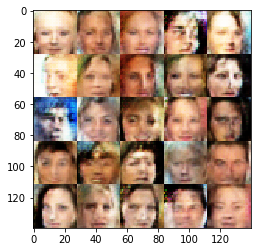

Epoch 2/7 Step 1900... Discriminator Loss: 1.5357... Generator Loss: 0.9115
Epoch 2/7 Step 2000... Discriminator Loss: 1.4102... Generator Loss: 0.4714


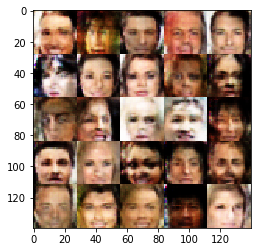

Epoch 2/7 Step 2100... Discriminator Loss: 1.3329... Generator Loss: 0.6802
Epoch 2/7 Step 2200... Discriminator Loss: 1.5414... Generator Loss: 0.4002


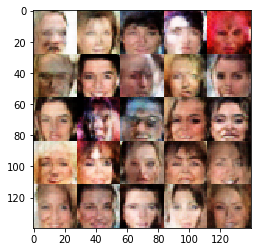

Epoch 2/7 Step 2300... Discriminator Loss: 1.3244... Generator Loss: 0.6396
Epoch 2/7 Step 2400... Discriminator Loss: 1.3136... Generator Loss: 0.8688


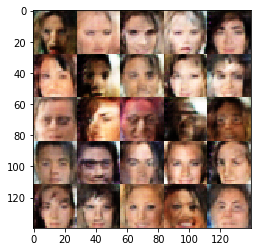

Epoch 2/7 Step 2500... Discriminator Loss: 1.3548... Generator Loss: 0.5694
Epoch 2/7 Step 2600... Discriminator Loss: 1.4690... Generator Loss: 0.4513


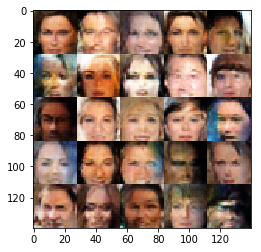

Epoch 2/7 Step 2700... Discriminator Loss: 1.4507... Generator Loss: 0.4740
Epoch 2/7 Step 2800... Discriminator Loss: 1.3960... Generator Loss: 0.5270


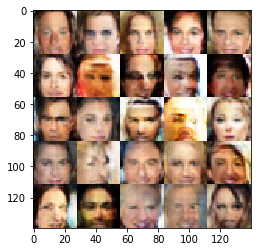

Epoch 2/7 Step 2900... Discriminator Loss: 1.4301... Generator Loss: 0.9077
Epoch 2/7 Step 3000... Discriminator Loss: 1.4501... Generator Loss: 0.4860


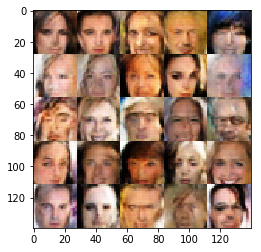

Epoch 2/7 Step 3100... Discriminator Loss: 1.4394... Generator Loss: 0.4762
Epoch 3/7 Step 3200... Discriminator Loss: 1.4203... Generator Loss: 0.7357


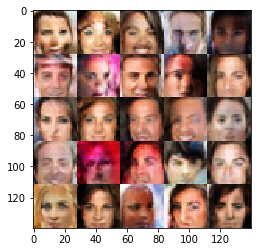

Epoch 3/7 Step 3300... Discriminator Loss: 1.4495... Generator Loss: 0.5336
Epoch 3/7 Step 3400... Discriminator Loss: 1.3336... Generator Loss: 0.7068


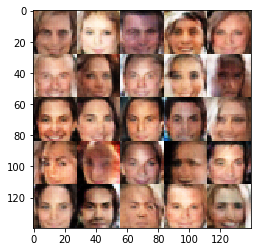

Epoch 3/7 Step 3500... Discriminator Loss: 1.3538... Generator Loss: 0.6201
Epoch 3/7 Step 3600... Discriminator Loss: 1.4588... Generator Loss: 0.8351


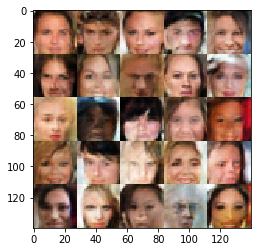

Epoch 3/7 Step 3700... Discriminator Loss: 1.6463... Generator Loss: 0.9915
Epoch 3/7 Step 3800... Discriminator Loss: 1.6347... Generator Loss: 0.3524


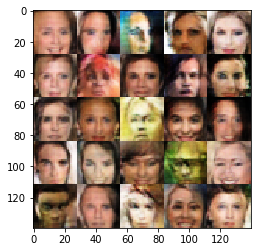

Epoch 3/7 Step 3900... Discriminator Loss: 1.5036... Generator Loss: 0.7185
Epoch 3/7 Step 4000... Discriminator Loss: 1.4349... Generator Loss: 0.5657


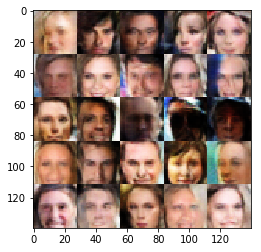

Epoch 3/7 Step 4100... Discriminator Loss: 1.4486... Generator Loss: 0.8613
Epoch 3/7 Step 4200... Discriminator Loss: 1.7651... Generator Loss: 0.3082


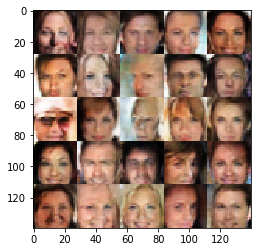

Epoch 3/7 Step 4300... Discriminator Loss: 1.4079... Generator Loss: 0.5985
Epoch 3/7 Step 4400... Discriminator Loss: 1.4586... Generator Loss: 0.5559


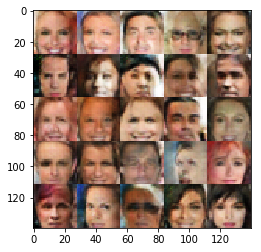

Epoch 3/7 Step 4500... Discriminator Loss: 1.4059... Generator Loss: 0.6241
Epoch 3/7 Step 4600... Discriminator Loss: 1.2599... Generator Loss: 0.6458


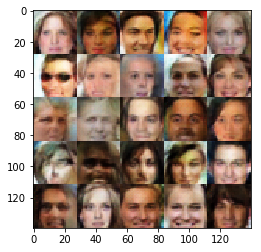

Epoch 3/7 Step 4700... Discriminator Loss: 1.5207... Generator Loss: 0.6960
Epoch 4/7 Step 4800... Discriminator Loss: 1.8784... Generator Loss: 0.2782


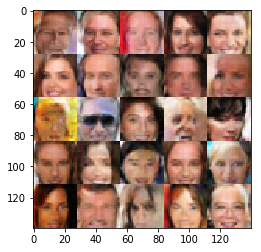

Epoch 4/7 Step 4900... Discriminator Loss: 1.4016... Generator Loss: 0.7135
Epoch 4/7 Step 5000... Discriminator Loss: 1.4222... Generator Loss: 0.5543


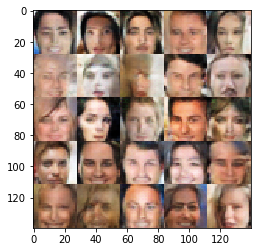

Epoch 4/7 Step 5100... Discriminator Loss: 1.1849... Generator Loss: 0.9353
Epoch 4/7 Step 5200... Discriminator Loss: 1.3622... Generator Loss: 0.6004


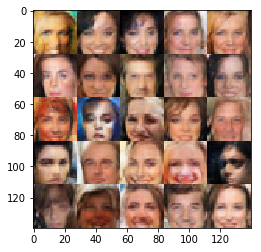

Epoch 4/7 Step 5300... Discriminator Loss: 1.3742... Generator Loss: 0.7448
Epoch 4/7 Step 5400... Discriminator Loss: 1.6276... Generator Loss: 0.3529


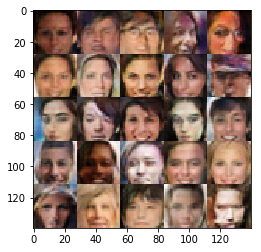

Epoch 4/7 Step 5500... Discriminator Loss: 1.3428... Generator Loss: 0.7166
Epoch 4/7 Step 5600... Discriminator Loss: 1.7283... Generator Loss: 0.3220


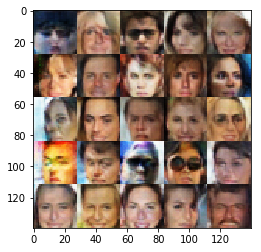

Epoch 4/7 Step 5700... Discriminator Loss: 1.4562... Generator Loss: 0.4483
Epoch 4/7 Step 5800... Discriminator Loss: 1.2801... Generator Loss: 0.7859


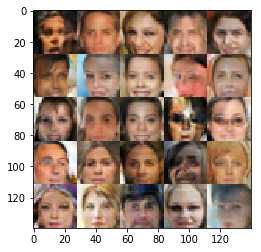

Epoch 4/7 Step 5900... Discriminator Loss: 1.3397... Generator Loss: 0.9175
Epoch 4/7 Step 6000... Discriminator Loss: 1.4722... Generator Loss: 0.4895


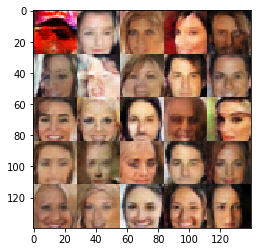

Epoch 4/7 Step 6100... Discriminator Loss: 1.4719... Generator Loss: 0.4534
Epoch 4/7 Step 6200... Discriminator Loss: 1.1370... Generator Loss: 1.3406


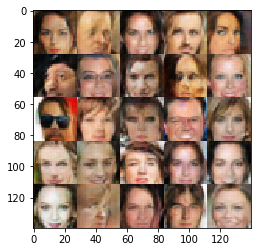

Epoch 4/7 Step 6300... Discriminator Loss: 1.2919... Generator Loss: 0.8197
Epoch 5/7 Step 6400... Discriminator Loss: 1.5712... Generator Loss: 1.1289


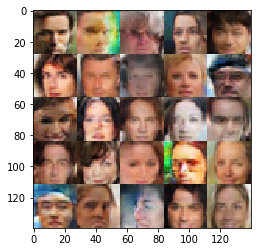

Epoch 5/7 Step 6500... Discriminator Loss: 1.5509... Generator Loss: 0.3834
Epoch 5/7 Step 6600... Discriminator Loss: 1.5554... Generator Loss: 0.3827


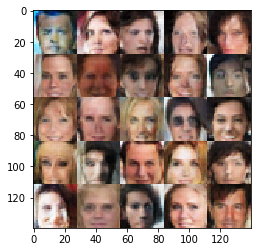

Epoch 5/7 Step 6700... Discriminator Loss: 1.3187... Generator Loss: 0.5571
Epoch 5/7 Step 6800... Discriminator Loss: 1.4007... Generator Loss: 0.8166


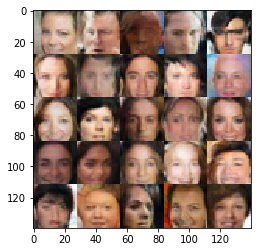

Epoch 5/7 Step 6900... Discriminator Loss: 1.2928... Generator Loss: 0.5728
Epoch 5/7 Step 7000... Discriminator Loss: 1.3418... Generator Loss: 0.8743


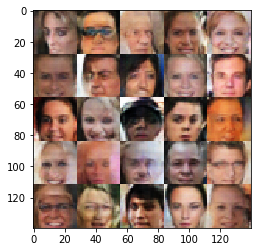

Epoch 5/7 Step 7100... Discriminator Loss: 1.4530... Generator Loss: 0.4371
Epoch 5/7 Step 7200... Discriminator Loss: 1.3987... Generator Loss: 1.0523


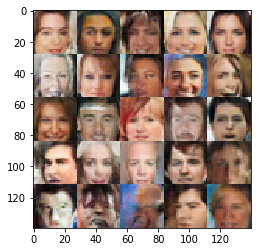

Epoch 5/7 Step 7300... Discriminator Loss: 1.1862... Generator Loss: 0.8879
Epoch 5/7 Step 7400... Discriminator Loss: 1.1066... Generator Loss: 0.8527


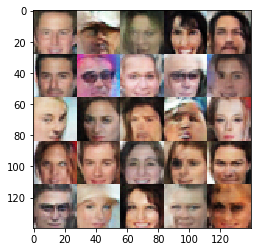

Epoch 5/7 Step 7500... Discriminator Loss: 1.3965... Generator Loss: 0.4945
Epoch 5/7 Step 7600... Discriminator Loss: 1.5833... Generator Loss: 0.3731


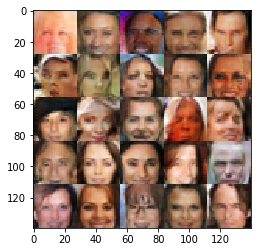

Epoch 5/7 Step 7700... Discriminator Loss: 1.2837... Generator Loss: 0.6767
Epoch 5/7 Step 7800... Discriminator Loss: 1.0327... Generator Loss: 0.9510


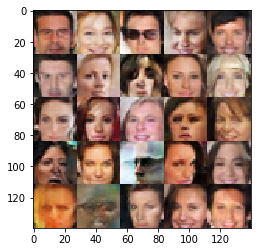

Epoch 5/7 Step 7900... Discriminator Loss: 1.3333... Generator Loss: 0.5222
Epoch 6/7 Step 8000... Discriminator Loss: 1.4171... Generator Loss: 0.4592


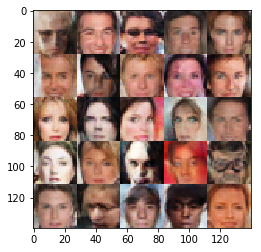

Epoch 6/7 Step 8100... Discriminator Loss: 1.2535... Generator Loss: 0.8550
Epoch 6/7 Step 8200... Discriminator Loss: 1.3284... Generator Loss: 0.7474


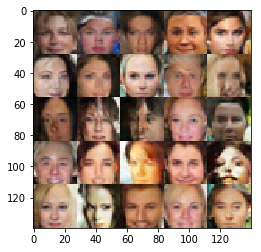

Epoch 6/7 Step 8300... Discriminator Loss: 1.2397... Generator Loss: 0.6827
Epoch 6/7 Step 8400... Discriminator Loss: 1.4080... Generator Loss: 0.4656


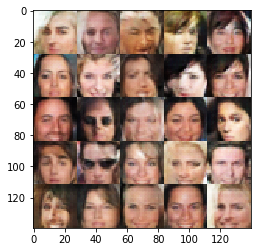

Epoch 6/7 Step 8500... Discriminator Loss: 1.1202... Generator Loss: 0.7117
Epoch 6/7 Step 8600... Discriminator Loss: 1.3680... Generator Loss: 0.4859


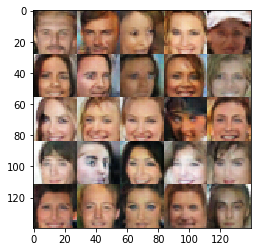

Epoch 6/7 Step 8700... Discriminator Loss: 1.0318... Generator Loss: 0.9143
Epoch 6/7 Step 8800... Discriminator Loss: 1.1983... Generator Loss: 0.6728


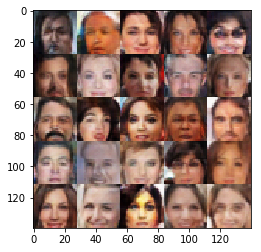

Epoch 6/7 Step 8900... Discriminator Loss: 1.4180... Generator Loss: 0.4675
Epoch 6/7 Step 9000... Discriminator Loss: 1.3385... Generator Loss: 0.5244


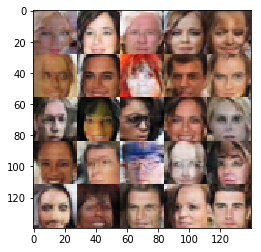

Epoch 6/7 Step 9100... Discriminator Loss: 1.3475... Generator Loss: 0.5194
Epoch 6/7 Step 9200... Discriminator Loss: 1.7494... Generator Loss: 0.3339


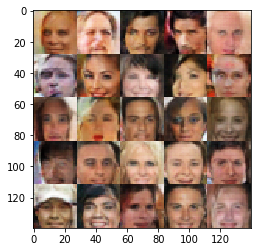

Epoch 6/7 Step 9300... Discriminator Loss: 1.1063... Generator Loss: 1.0221
Epoch 6/7 Step 9400... Discriminator Loss: 1.2055... Generator Loss: 1.0387


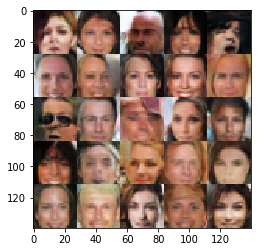

Epoch 7/7 Step 9500... Discriminator Loss: 1.2009... Generator Loss: 1.3493
Epoch 7/7 Step 9600... Discriminator Loss: 2.0199... Generator Loss: 0.2841


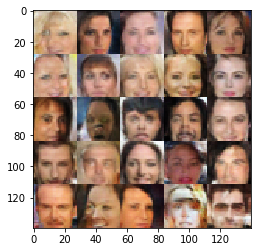

Epoch 7/7 Step 9700... Discriminator Loss: 1.0212... Generator Loss: 0.9005
Epoch 7/7 Step 9800... Discriminator Loss: 1.2491... Generator Loss: 0.6407


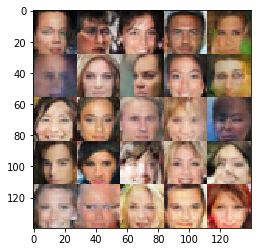

Epoch 7/7 Step 9900... Discriminator Loss: 1.7515... Generator Loss: 0.3664
Epoch 7/7 Step 10000... Discriminator Loss: 1.1447... Generator Loss: 1.1191


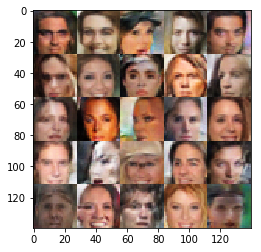

Epoch 7/7 Step 10100... Discriminator Loss: 1.1571... Generator Loss: 1.0785
Epoch 7/7 Step 10200... Discriminator Loss: 1.3725... Generator Loss: 1.5141


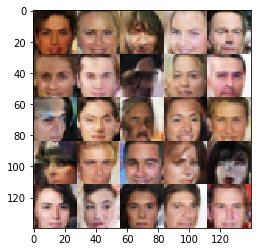

Epoch 7/7 Step 10300... Discriminator Loss: 1.4034... Generator Loss: 0.4896
Epoch 7/7 Step 10400... Discriminator Loss: 1.1196... Generator Loss: 0.7001


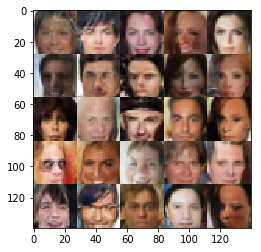

Epoch 7/7 Step 10500... Discriminator Loss: 1.0104... Generator Loss: 0.9257
Epoch 7/7 Step 10600... Discriminator Loss: 1.1213... Generator Loss: 0.8596


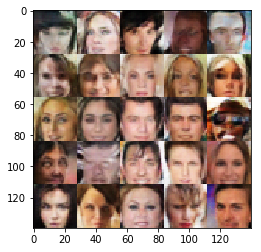

Epoch 7/7 Step 10700... Discriminator Loss: 1.1833... Generator Loss: 0.8902
Epoch 7/7 Step 10800... Discriminator Loss: 1.2279... Generator Loss: 1.4420


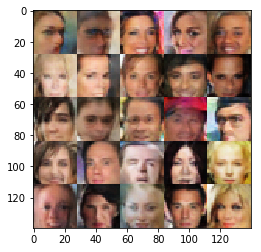

Epoch 7/7 Step 10900... Discriminator Loss: 1.4909... Generator Loss: 0.4644
Epoch 7/7 Step 11000... Discriminator Loss: 1.0804... Generator Loss: 0.8516


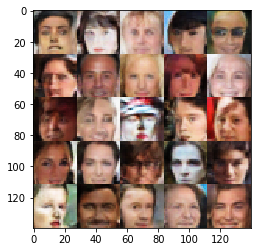

In [14]:
batch_size = 128
z_dim = 100
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 7

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.